In [1]:

import torch
import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset

import librosa
import librosa.display
import numba.decorators
import numpy as np
import matplotlib.pyplot as plt
from numba.decorators import jit as optional_jit




from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')


#PATH = 'C://Projects//keras_talk//keras//intern//dataset//'
PATH = '/content/gdrive/My Drive/dataset/'


BATCH_SIZE = 40




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#
###### y_data 
class를

0 ~ 180 까지는 20으로 나눠주어서 [0~9]로

-1(음성이 없는경우)는 10으로 구성하였습니다.

In [2]:
def Y_DATA(y_data):
    for idx in range(y_data.shape[0]):
        y = y_data[idx]
        if y < 0:  y_data[idx] = 10
        else:      y_data[idx] = (y//20)
    return y_data

In [3]:

dataset_dict = { 0 : 'S_left',        1 : 'S_left_phase',
                 2 : 'S_right',       3 : 'S_right_phase',
                 4 : 'clean_left',    5 : 'clean_left_phase',
                 6 : 'clean_right',   7 : 'clean_right_phase',
                 8 : 'idx_drone_end', 9 : 'idx_voice_end',
                10 : 'idx_voice_start'}



In [4]:
y_data =  np.load(PATH + 'angle.npy') 

x_data_list = [0,2,1,3]
numpy_dict = dict()

for n in x_data_list:
    numpy_name    = dataset_dict[n]
    numpy_dict[n] = np.load( PATH + numpy_name + '.npy' )


# .shape = (257, 382, 1000)
S_L_mag = numpy_dict[0]
S_L_phase = numpy_dict[1]
S_R_mag = numpy_dict[2]
S_R_phase = numpy_dict[3]



# 

##### x_data 전처리

1) x_data list 초기화

2) (for) total data 개수인 1000번동안

    -left, right mag의 idx 번째 array(257,382) 불러오기
    -magnitude log 변환
    -left, right phase의 idx 번째 array(257,382) 불러오기

    -초기화된 list인 x_element에 삽입 (4,257,382)
    - x_element의 원소들 정규화

    - x_element의 type을 numpy array로 변환 후 x_data에 삽입

3) type(x_data)을 numpy array로 변환

In [5]:

# x_data 초기화
x_data = []


'''    x_data,       y_data '''
'''(1000,4,257,382), (1000,)'''


for idx in range(1000):
    
    # list 초기화
    x_element = []


    """ Mag """
    # S_left,  S_right 의 idx번째 array
    x_L = S_L_mag[:,:,idx]
    x_R = S_R_mag[:,:,idx]

    """log scale [dB]"""
    x_L = 20*np.log10( np.abs(x_L) + np.finfo(np.float16).eps )
    x_R = 20*np.log10( np.abs(x_R) + np.finfo(np.float16).eps )
    #x_L = librosa.amplitude_to_db(x_L)
    #x_R = librosa.amplitude_to_db(x_R)
    


    """phase"""
    # S_left_phase,  S_right_phase 의 idx번째 array
    x_L_phase = S_L_phase[:,:,idx]
    x_R_phase = S_R_phase[:,:,idx]



 #   """even mode, odd mode""" 
 #   x_even = (x_L + x_R)/2
 #   x_odd  = (x_L - x_R)/2
 #   x_element.append(x_even)
 #   x_element.append(x_odd)
    
    
    """x_element.shape ==> (4, 257, 382)"""
    # 초기화된 list( x_element )에 
    # left, right의 mag[dB], phase[rad] 총 4개의 array 삽입 
    x_element.append(x_L)
    x_element.append(x_R)
    x_element.append(x_L_phase)
    x_element.append(x_R_phase)



    """normalization"""
    for k in range(len(x_element)):
        x_mean = x_element[k].mean()
        x_stdv = x_element[k].std()
        x_element[k] = ( (x_element[k] - x_mean ) / x_stdv)
    

    # x_element 의 type을 list에서 numpy array로 변환후 
    #x_data list에 삽입
    x_data.append( np.asarray(x_element) )



# x_data의 type을 list에서 numpy array로 변환
x_data = np.asarray(x_data)

# 0,20,40,60...180,-1 인 y_data를  Y_DATA 함수로 
# 0,1,2,....,9,10 으로 변환
y_data = Y_DATA( y_data )

print('done...')


done...


In [6]:

train_size = 800
valid_size = 200


x_data = torch.from_numpy( x_data ).float().to('cuda')
y_data = torch.from_numpy( y_data ).long().to('cuda')

full_dataset = TensorDataset( x_data, y_data )

# 8:2 비율로 랜덤
train_dataset, valid_dataset = torch.utils.data.random_split( full_dataset, [train_size, valid_size])
train_dataset = DataLoader( dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataset = DataLoader( dataset=valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)


CNN Model은 이전에 MNIST분류에 사용한 model에서

convolution layer 한 개를 추가하였습니다.


첫번째 convolution layer에서 kernel size는 (7,7) stride가 (2,2)이고

, 두번째, 세번째 convolution layer에서 kernel size는 (3,3) stride는 (1,1)입니다.



In [10]:
import re
import torch.nn as nn
import torch.nn.functional as F



class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ''' 4 * 257 * 382'''
        self.conv1 = nn.Conv2d( in_channels= 4, out_channels= 64, kernel_size = (7,7), stride = (2,2) )
        #relu
        #pooling
        
        ''' 64 * 62 * 94'''
        self.conv2 = nn.Conv2d( in_channels= 64, out_channels= 64, kernel_size = (3,3) )
        #relu
        #pooling


        ''' 64 * 30 * 46'''
        self.conv3 = nn.Conv2d( in_channels= 64, out_channels= 32, kernel_size = (3,3) )
        #relu
        #pooling


        ''' 32 * 14 * 22'''
        #flatten

        self.lay1  = nn.Linear( 32*14*22, 256)
        self.lay2  = nn.Linear( 256, 256 )
        self.lay3  = nn.Linear( 256, 64 )
        self.lay4  = nn.Linear( 64 , 11 )
        
        
        
    def forward(self, output):
        output = F.max_pool2d( F.relu( self.conv1(output) ),2 )
        output = F.max_pool2d( F.relu( self.conv2(output) ),2 )
        output = F.max_pool2d( F.relu( self.conv3(output) ),2 )
        
        output = output.view(-1, 32*14*22)
        
        output = F.relu( self.lay1(output) )
        output = F.dropout(output, training=self.training)
        output = F.relu( self.lay2(output) )
        output = F.dropout(output, training=self.training)
        output = F.relu( self.lay3(output) )
        output = F.dropout(output, training=self.training)
        output = F.log_softmax(self.lay4(output), dim=1)
        
        return output
    

In [11]:

model = CNN().to('cuda')
model


CNN(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (lay1): Linear(in_features=9856, out_features=256, bias=True)
  (lay2): Linear(in_features=256, out_features=256, bias=True)
  (lay3): Linear(in_features=256, out_features=64, bias=True)
  (lay4): Linear(in_features=64, out_features=11, bias=True)
)

###### Model 학습

epoch 50, batch size 40

optimizer

    - Adagrad
    - Adam
    - SGD



In [53]:



torch.manual_seed(1)
criterion = nn.CrossEntropyLoss().to('cuda')



'''optimizer'''

#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.00001, weight_decay=0.9)
#TITLE = 'Adagrad'

#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#TITLE = 'Adam'

optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, weight_decay=0.9)
TITLE = 'SGD'





EPOCHS = 50
train_loss = []
train_acc  = []


model.train()
for epoch in range(EPOCHS):
    print('epoch' + str(epoch+1))
    total_loss = 0.0
    total_acc = 0
    
    
    for i, (data, label) in enumerate(train_dataset):
        (data, label) = (data.to('cuda'), label.to('cuda'))

        #zero the parameter gradients
        optimizer.zero_grad()
        output = model(data)
        
        # forward + backward = optimize
        loss = F.nll_loss(output, label.reshape(BATCH_SIZE))
        loss.backward()
        optimizer.step()
        

        # batch 정확도
        preds = output.data.max(1)[1]
        corr  = (preds==label.reshape(BATCH_SIZE)).sum().item()
        acc   = corr/BATCH_SIZE*100

        
        # epoch 손실도, 정확도
        total_loss += loss.item()
        total_acc += corr
        

        # batch 손실도, 정확도 출력, 저장
        train_loss.append(loss)
        train_acc.append(acc)
        if i%5==0: print('\tLoss: {:.3f}\tAcc: {:.3f}'.format(loss.item(), acc))

    # epoch 손실도, 정확도 출력
    print('epoch' + str(epoch+1) + '  >> Loss: {:.3f}\tAcc: {:.3f}'.format( total_loss, total_acc/800*100 ))
    print()

epoch1
	Loss: 2.396	Acc: 5.000
	Loss: 2.393	Acc: 15.000
	Loss: 2.396	Acc: 17.500
	Loss: 2.395	Acc: 5.000
epoch1  >> Loss: 47.930	Acc: 10.625

epoch2
	Loss: 2.398	Acc: 5.000
	Loss: 2.395	Acc: 12.500
	Loss: 2.397	Acc: 7.500
	Loss: 2.399	Acc: 15.000
epoch2  >> Loss: 47.930	Acc: 10.625

epoch3
	Loss: 2.396	Acc: 10.000
	Loss: 2.394	Acc: 10.000
	Loss: 2.396	Acc: 10.000
	Loss: 2.396	Acc: 15.000
epoch3  >> Loss: 47.931	Acc: 10.625

epoch4
	Loss: 2.395	Acc: 12.500
	Loss: 2.395	Acc: 7.500
	Loss: 2.396	Acc: 12.500
	Loss: 2.397	Acc: 7.500
epoch4  >> Loss: 47.931	Acc: 10.625

epoch5
	Loss: 2.396	Acc: 7.500
	Loss: 2.392	Acc: 15.000
	Loss: 2.395	Acc: 10.000
	Loss: 2.398	Acc: 15.000
epoch5  >> Loss: 47.930	Acc: 10.625

epoch6
	Loss: 2.399	Acc: 12.500
	Loss: 2.400	Acc: 0.000
	Loss: 2.397	Acc: 12.500
	Loss: 2.399	Acc: 7.500
epoch6  >> Loss: 47.930	Acc: 10.625

epoch7
	Loss: 2.396	Acc: 12.500
	Loss: 2.397	Acc: 7.500
	Loss: 2.398	Acc: 15.000
	Loss: 2.394	Acc: 12.500
epoch7  >> Loss: 47.930	Acc: 10.625

ep

training loss, training accuracy

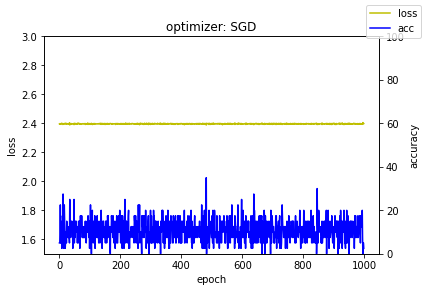

In [54]:

%matplotlib inline
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(np.asarray(train_loss), 'y')
acc_ax.plot( np.asarray(train_acc),  'b')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.set_ylim([1.5, 3])

acc_ax.set_ylabel('accuracy')
acc_ax.set_ylim([0, 100])

fig.legend(['loss','acc'], loc='upper right')
plt.title('optimizer: '+TITLE)
plt.savefig(TITLE+'.png')
plt.show()

In [56]:
model.eval().to('cuda')

val_loss = []
val_acc = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, label in valid_dataset:
        output = model(data)
        preds  = torch.max(output.data, 1)[1]
        total   += len(label)
        
        label = label.reshape(BATCH_SIZE)
        correct += (preds==label).sum().item()


        val_loss.append
      
    print('Test Accuracy: ', 100.*correct/total)

Test Accuracy:  12.0
